In [1]:
%matplotlib notebook
from matplotlib import pyplot as plt
import numpy as np
import random
import copy
from matplotlib import animation
from matplotlib import rc
rc('animation', html='jshtml')

In [2]:
velocities = np.array([[1, 0], 
                      [0, 1],
                      [-1, 0],
                      [0, -1]])

In [3]:
def distance(u, v):
  return np.linalg.norm(u - v)

### BEGIN CLASS DEFINITIONS ###

class Plane:
  def __init__(self, source=np.array([0, 0]), target=np.array([0, 0]), velocity=np.array([1, 0])):
    self.source = source
    self.location = source
    self.target = target
    self.velocity = velocity
    self.commlst = []

  # updates the planes location according to velocity and returns the new position
  def update(self):
    self.location = self.location + self.velocity
    return self.location

  def controller(self):
    # if plane is in communication distance with other planes act one way
    if len(self.commlst) > 0:
      for plane2 in self.commlst:
        # get the displacement and displacement direction of the other plane relative to this plane
        displacement = plane2.location - self.location
        if np.linalg.norm(displacement) > 0:
          displacement_direction =  displacement / np.linalg.norm(displacement)
        else: 
          displacement_direction = np.array([0, 0])

        # get the velocity and direction of this plane relative to the other plane
        relative_velocity = self.velocity - plane2.velocity
        if np.linalg.norm(relative_velocity) > 0:
          relative_velocity_direction = relative_velocity / np.linalg.norm(relative_velocity)
        else:
          relative_velocity_direction = np.array([0, 0])

        # on collision course if the relative velocity and displacement is in the same direction
        if np.all((relative_velocity_direction == displacement_direction)):
          # if on collision course, only one needs to turn
          self.choose_right_left()
          return
        # else if a plane is getting further from its destination, it needs to turn
        elif distance(self.location + self.velocity, self.target) >= distance(self.location, self.target): 
          left_turn_relative_velocity_direction = (self.get_left() - plane2.velocity) / np.linalg.norm(self.get_left() - plane2.velocity)
          right_turn_relative_velocity_direction = (self.get_right() - plane2.velocity) / np.linalg.norm(self.get_right() - plane2.velocity)
          # check if left turn makes collision
          if np.all((left_turn_relative_velocity_direction == displacement_direction)):
            self.turn_right()
          # check if right turn makes collision
          elif np.all((right_turn_relative_velocity_direction == displacement_direction)):
            self.turn_left()
          # else choose based on direction to target
          else:
            self.choose_right_left()
          return
    # else ignore all other planes
    elif distance(self.location + self.velocity, self.target) >= distance(self.location, self.target):
      self.choose_right_left()

  # get the vector corresponding to a left turn
  def get_left(self):
    idx = list(np.where(np.all(velocities==self.velocity,axis=1)))[0][0]
    v = velocities[(idx + 1) % len(velocities)]
    return v

  # get a vector corresponding to a right turn
  def get_right(self):
    idx = list(np.where(np.all(velocities==self.velocity,axis=1)))[0][0]
    v = velocities[(idx - 1) % len(velocities)]
    return v

  # turns the plane left
  def turn_left(self):
    v = self.get_left()
    self.velocity = v
    return v

  # turns the plane right
  def turn_right(self):
    v = self.get_right()
    self.velocity = v
    return v

  # chooses whether to go left or right based on target, not locations of other planes
  def choose_right_left(self):
    if distance(self.location + self.get_left(), self.target) > distance(self.location, self.target):
      self.turn_right()
    else:
      self.turn_left()



class Simulate:
  colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

  def __init__(self, planes, size=(100, 100), frames=100, raise_error=False):
    self.planes = planes
    if not raise_error:
      self.fig, self.ax = plt.subplots()
      self.ani = animation.FuncAnimation(self.fig, 
                                                  self.update, 
                                                  init_func=self.init_plot, 
                                                  blit=True,
                                                  frames=frames,
                                                  repeat=True
                                                  )
    self.size = size
    # default minimum communication distance is distance from (0, 0) to (2, 2) as comm diameter is 4
    self.communication_distance = distance(np.array([0, 0]), np.array([2, 2]))
    # danger distance is distance to (.5, .5) because danger diameter is 1
    self.danger_distance = np.linalg.norm(np.array([.5, .5]))

    self.raise_error = raise_error


  def update_planes(self):
    for plane1 in self.planes:
      # if the plane is at its target we remove it from the list
      if np.all((plane1.target == plane1.location)):
        self.planes.remove(plane1)
      # get all the planes each other plane can talk to
      else:
        plane1.commlst = []
        for plane2 in self.planes:
          if plane1 != plane2 and distance(plane1.location, plane2.location) <= self.communication_distance:
            plane1.commlst.append(plane2)

      # now that the planes comm list is build we can execute the planes controller
      plane1.controller()

    # now update each plane based on what happened in controller
    for plane in self.planes:
      plane.update()

    # now check if all planes are in safe state
    if self.raise_error:
      for p1 in self.planes:
        for p2 in self.planes:
          if p1 != p2 and distance(p1.location, p2.location) < self.danger_distance:
            e = 'Planes in unsafe state.  \n'
            e += 'Plane 1 source, target: ' + str(p1.source) + ', ' + str(p1.target) + '\n'
            e += 'Plane 2 source, target: ' + str(p2.source) + ', ' + str(p2.target) + '\n'
            raise ValueError(e)

  def init_plot(self):
    for i, plane in enumerate(self.planes):
      plane_marker = '^'
      src_marker = 'o'
      targ_marker = '*'
      c = self.colors[i]

      # plot the plane
      self.ax.scatter(plane.location[0], plane.location[1], color=c, marker=plane_marker)
      # plot the source
      self.ax.scatter(plane.source[0], plane.source[1], color=c, marker=src_marker)
      self.scat = self.ax.scatter(plane.target[0], plane.target[1], color=c, marker=targ_marker)

    self.ax.axis([0, self.size[0], 0, self.size[1]])
    return self.scat, 

  def update(self, j):
    self.ax.clear()
    for i, plane in enumerate(self.planes):
      plane_marker = '^'
      src_marker = 'o'
      targ_marker = '*'
      c = self.colors[i]

      # plot the plane
      self.ax.scatter(plane.location[0], plane.location[1], color=c, marker=plane_marker)
      # plot the source
      self.ax.scatter(plane.source[0], plane.source[1], color=c, marker=src_marker)
      # plot the target
      self.scat = self.ax.scatter(plane.target[0], plane.target[1], color=c, marker=targ_marker)

    self.ax.axis([0, self.size[0], 0, self.size[1]])
    self.ax.grid()

    self.update_planes()

    return self.scat,

  def save(path):
    return

### END CLASS DEFINITIONS ###

In [4]:
def get_random_location(grid):
  row = random.choice(grid)
  el = random.choice(row)
  return el

def gen_random_planes(n_planes, size=(100, 100)):
  grid = [[[i, j] for j in range(size[1])] for i in range(size[0])]

  planes = []
  for i in range(n_planes):
    source = np.array(get_random_location(grid))
    target = np.array(get_random_location(grid))
    velocity = np.array(random.choice(velocities))
    plane = Plane(source=source, target=target, velocity=velocity)
    planes.append(plane)
  return planes

def get_head2head_planes():
  src1 = np.array([5, 5])
  targ1 = np.array([25, 5])
  vel1 = np.array([1, 0])
  p1 = Plane(src1, targ1, vel1)

  src2 = targ1
  targ2 = src1
  vel2 = -vel1
  p2 = Plane(src2, targ2, vel2)
  return [p1, p2]

def get_perp_planes():
  src1 = np.array([10, 0])
  targ1 = np.array([10, 20])
  vel1 = np.array([0, 1])
  p1 = Plane(src1, targ1, vel1)

  src2 = np.array([0, 10])
  targ2 = np.array([20, 10])
  vel2 = np.array([1, 0])
  p2 = Plane(src2, targ2, vel2)
  return [p1, p2]

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py", line 196, in process
    func(*args, **kwargs)
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 951, in _start
    self._init_draw()
  File "/usr/local/lib/python3.7/dist-packages/matplotlib/animation.py", line 1746, in _init_draw
    self._drawn_artists = self._init_func()
  File "<ipython-input-3-27beca21db56>", line 158, in init_plot
    self.ax.axis([0, self.size[0], 0, self.size[1]])
AttributeError: 'Simulate' object has no attribute 'size'


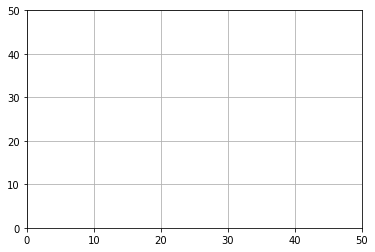

In [7]:
n_planes = 2
size=(50, 50)
planes = gen_random_planes(n_planes=n_planes, size=size)
# planes = get_head2head_planes()
# planes = get_perp_planes()

# p1 = Plane(source=np.array([10, 10]), target=np.array([8, 8]), velocity=np.array([0, 1]))
# p2 = Plane(source=np.array([8, 8]), target=np.array([8, 9]), velocity=np.array([0, -1]))
# planes = [p1, p2]

sim = Simulate(planes=planes, frames=75, size=size)
sim.ani

In [ ]:
### SAFETY VERIFICATION ###

# get all possible orientations for two planes meeting
def get_all_possible_meets():
  src1 = np.array([0, 0])
  scenarios = []
  # try every location for plane2
  for src2x in range(-2, 3):
    for src2y in range(-2, 3):
      for targ1x in range(-2, 3):
        for targ1y in range(-2, 3):
          for targ2x in range(-2, 3):
            for targ2y in range(-2, 3):
              # get all possible velocities
              for v1 in velocities:
                for v2 in velocities:
                  targ1 = np.array([targ1x, targ1y])
                  p1 = Plane(source=src1, target=targ1, velocity=v1)

                  src2 = np.array([src2x, src2y])
                  targ2 = np.array([targ2x, targ2y])
                  p2 = Plane(src2, targ2, v2)

                  if not np.all(src1 == src2) and not np.all(src1 == targ1) and not np.all(src2 == targ2):
                    scenarios.append([p1, p2])
  return scenarios

# print(len(get_all_possible_meets()))

In [ ]:
# iterate through every possible plane meet up
for planes in get_all_possible_meets():
  v1_init, v2_init = planes[0].velocity, planes[1].velocity
  sim = Simulate(planes, raise_error=True)
  # complete the simulation
  # if there is a collision it will raise error
  try:
    while len(sim.planes) != 0:
      sim.update_planes()
  except Exception as e: 
    print('v1: ', str(v1_init))
    print('v2: ', str(v2_init))
    print(e)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
